In [1]:
import uuid
import random
import tqdm
import requests
import json
import json5
import fire 
from PIL import Image
from io import BytesIO



from pydantic import BaseModel, Field
from typing_extensions import (Annotated, TypedDict, Sequence, Union, Optional, Literal, List, Dict)



from langchain_core.tools import InjectedToolCallId, BaseTool
from langchain.tools import tool
from langchain_ollama import ChatOllama
from langchain_core.messages import (HumanMessage, AIMessage, SystemMessage, BaseMessage, ToolMessage)
from langchain_core.prompts import PromptTemplate



from langgraph.types import Command, interrupt
from langgraph.graph.message import add_messages
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.managed import IsLastStep
from langgraph.graph import (MessagesState, StateGraph, START, END)
from langgraph.prebuilt import (create_react_agent, ToolNode, tools_condition)



from tools import (add, subtract, multiply, divide, power, square_root)
from prompts_lib import Prompts 

In [ ]:
begin_of_text = "<|begin_of_text|>"
end_of_text = "<|end_of_text|>"
start_header_id = "<|start_header_id|>"
end_header_id = "<|end_header_id|>"
end_of_message_id = "<|eom_id|>"
end_of_turn_id = "<|eot_id|>"



TOOLS = [add, subtract, multiply, divide, power, square_root]



MESSAGE_TYPES = {SystemMessage: "SYSTEM", HumanMessage: "HUMAN", AIMessage: "AI"}



def add_unique_messages(
		messages: Dict[str, List[BaseMessage]], 
		message: BaseMessage
	) -> None:
	"""Custom reducer, adds a message to the appropriate category if it does not already exist."""

	category = MESSAGE_TYPES.get(type(message))
	if category and all(message.content != msg.content for msg in messages[category]):
		messages[category].append(message)



class State(BaseModel):
	"""Represents the structured conversation state with categorized messages."""
	user_query: Annotated[List, add_messages] = Field(default_factory=list)
	messages: Dict[str, Annotated[List[BaseMessage], add_unique_messages]] = Field(
		default_factory=lambda: {
			"SYSTEM": [], 
			"HUMAN": [], 
			"AI": []
		}, description="Categorized messages: SYSTEM, HUMAN, AI."
	)
	is_last_step: bool = False
	remaining_steps: int = 3

	def get_all_messages(self) -> List[BaseMessage]:
		"""Returns all messages in chronological order."""
		return sum(self.messages.values(), [])

	def get_latest_message(self, category: str) -> BaseMessage:
		"""Returns the latest message from a given category, if available."""
		if category not in self.messages:
			raise ValueError(f"[ERROR]: Invalid category '{category}'. Must be 'SYSTEM', 'HUMAN', or 'AI'.")
		return self.messages[category][-1] if self.messages[category] else None 

	def get_messages_by_category(self, category: str) -> List[BaseMessage]:
		"""Returns all messages from a specific category."""
		if category not in self.messages:
			raise ValueError(f"[ERROR]: Invalid category '{category}'. Must be 'SYSTEM', 'HUMAN', or 'AI'.")
		return self.messages[category]



def enhance_human_msg(state: State) -> HumanMessage:
	"""Enhances the human query by formatting it with system and assistant structure.

	This function constructs a structured prompt including:
	- `system_prompt (from context)
	- `user_query (latest human query)
	- `ai_resp (space for AI response)

	Args:
		state (State): The current conversation state.

	Returns:
		HumanMessage: A formatted human query wrapped with special tokens.

	Example:
		>>> state.user_query = [HumanMessage(content="What is AI?")]
		>>> enhance_human_query(state)
		HumanMessage(content='<|start_header_id|>user<|end_header_id|>What is AI?<|end_of_turn_id|><|start_header_id|>assistant<|end_header_id|>')
	"""
	user_query = state.user_query[-1].content if state.user_query else ""
	formatted_query = (
		f"{start_header_id}user{end_header_id}"
		f"{user_query}"
		f"{end_of_turn_id}"
		f"{start_header_id}assistant{end_header_id}"
	)
	return HumanMessage(content=formatted_query)



def add_eot_id_to_ai_message(ai_message: AIMessage, special_token: str = end_of_turn_id) -> AIMessage:
	"""Appends a special token at the end of an AIMessage's content if it's not already present.

	This function ensures that the AI-generated message always ends with the specified special token.
	If the message already contains the token at the end, it remains unchanged.

	Args:
		ai_message (AIMessage): The AI-generated message.
		special_token (str, optional): The special token to append (default is `end_of_turn_id`).

	Returns:
		AIMessage: The updated AI message with the special token appended if necessary.

	Example:
		>>> message = AIMessage(content="Hello, how can I assist you?")
		>>> add_eot_id_to_ai_message(message, special_token="<|eot_id|>")
		AIMessage(content="Hello, how can I assist you?<|eot_id|>")
	"""
	if not ai_message.content.strip().endswith(special_token):
		return AIMessage(content=ai_message.content.strip() + special_token)
	return ai_message 



def build_react_sys_msg_prompt(tool_desc_prompt: str, react_prompt: str, tools: List[BaseTool])-> str:
	"""Builds a formatted system prompt with tool descriptions.

	Args:
		tool_desc_prompt (PromptTemplate): Template for tool descriptions.
		react_prompt (PromptTemplate): Template for constructing the final system prompt.
		tools (List[BaseTool]): List of tool objects.

	Returns:
		str: A fully formatted system prompt with tool descriptions.
	"""
	list_tool_desc = [
		tool_desc_prompt.format(
			name_for_model=(tool_info := getattr(tool.args_schema, "model_json_schema", lambda: {})()).get("title", "Unknown Tool"),
			name_for_human=tool_info.get("title", "Unknown Tool"),
			description_for_model=tool_info.get("description", "No description available."),
			type=tool_info.get("type", "N/A"),
			properties=json.dumps(tool_info.get("properties", {}), ensure_ascii=False),
			required=json.dumps(tool_info.get("required", []), ensure_ascii=False),
		) + " Format the arguments as a JSON object."
		for tool in tools
	]
	prompt = react_prompt.format(
		begin_of_text=begin_of_text, 
		start_header_id=start_header_id, 
		end_header_id=end_header_id, 
		end_of_turn_id=end_of_turn_id, 
		tools_desc="\n\n".join(list_tool_desc), 
		tools_name=", ".join(tool.name for tool in tools),
	)
	return prompt

In [4]:
MGR_SYS_MSG_PROMPT = SystemMessage(Prompts.AGENT_MANAGER_PROMPT)
REACT_SYS_MSG_PROMPT = SystemMessage(build_react_sys_msg_prompt(tool_desc_prompt=Prompts.TOOL_DESC_PROMPT, react_prompt=Prompts.REACT_PROMPT, tools=TOOLS))



CONFIG = {"configurable": {"thread_id": str(uuid.uuid4())}}
CHECKPOINTER = MemorySaver()
STORE = InMemoryStore()



HIGH_TEMP_MODEL = ChatOllama(model="llama3.2:1b-instruct-fp16", temperature=0.8, num_predict=128_000)
LOW_TEMP_MODEL = ChatOllama(model="llama3.2:1b-instruct-fp16", temperature=0.1, num_predict=128_000)
BIND_TOOLS_MODEL = LOW_TEMP_MODEL.bind_tools(tools=TOOLS)



def react_agent():
	# """ReAct Agent."""
	# human_msg = enhance_human_msg(state=state)
	# resp = HIGH_TEMP_MODEL.invoke([REACT_SYS_MSG_PROMPT, human_msg])
	# if not isinstance(resp, AIMessage):
	# 	resp = AIMessage(
	# 		content=resp.strip() 
	# 		if isinstance(resp, str) 
	# 		else "At node-react-agent, I'm unable to generate a response."
	# 	)
	# resp = add_eot_id_to_ai_message(ai_message=resp, special_token=end_of_turn_id)
	# return {"messages": {
	# 	"SYSTEM": [REACT_SYS_MSG_PROMPT], 
	# 	"HUMAN": [human_msg], 
	# 	"AI": [resp]
	# }}
	pass



def manager_agent():
	# """Manager Agent."""
	# human_msg = enhance_human_msg(state=state)
	# resp = LOW_TEMP_MODEL.invoke([MGR_SYS_MSG_PROMPT, human_msg])
	# if not isinstance(resp, AIMessage):
	# 	resp = AIMessage(
	# 		content=resp.strip() 
	# 		if isinstance(resp, str) 
	# 		else "At node-mgr-agent, I'm unable to generate a response."
	# 	)
	# resp = add_eot_id_to_ai_message(ai_message=resp, special_token=end_of_turn_id)
	# return {"messages": {
	# 	"SYSTEM": [MGR_SYS_MSG_PROMPT], 
	# 	"HUMAN": [human_msg], 
	# 	"AI": [resp]
	# }}
	pass



def prompt_agent():
	# "Prompt Agent."
	# human_msg = HumanMessage(content="")
	# resp = AIMessage(content="")
	# return {"messages": {
	# 	"SYSTEM": [MGR_SYS_MSG_PROMPT], 
	# 	"HUMAN": [human_msg], 
	# 	"AI": [resp]
	# }}
	pass



def data_agent():
	# """Data Agent."""
	# human_msg = HumanMessage(content="")
	# resp = AIMessage(content="")
	# return {"messages": {
	# 	"SYSTEM": [MGR_SYS_MSG_PROMPT], 
	# 	"HUMAN": [human_msg], 
	# 	"AI": [resp]
	# }}
	pass



def model_agent():
	# """Model Agent."""
	# human_msg = HumanMessage(content="")
	# resp = AIMessage(content="")
	# return {"messages": {
	# 	"SYSTEM": [MGR_SYS_MSG_PROMPT], 
	# 	"HUMAN": [human_msg], 
	# 	"AI": [resp]
	# }}
	pass



def op_agent():
	# """Operation Agent."""
	# human_msg = HumanMessage(content="")
	# resp = AIMessage(content="")
	# return {"messages": {
	# 	"SYSTEM": [MGR_SYS_MSG_PROMPT], 
	# 	"HUMAN": [human_msg], 
	# 	"AI": [resp]
	# }}
	pass 

In [ ]:
workflow = StateGraph(State)

workflow.add_node("react_agent", react_agent)
workflow.add_node("manager_agent", manager_agent)
workflow.add_node("prompt_agent", prompt_agent)
workflow.add_node("data_agent", data_agent)
workflow.add_node("model_agent", model_agent)
workflow.add_node("op_agent", op_agent)

# TODO: Sắp xếp lại workflow 
workflow.add_edge(START, "manager_agent")
workflow.add_conditional_edges("manager_agent", "prompt_agent")
workflow.add_edge("manager_agent", "react_agent")
workflow.add_edge("react_agent", END)

app = workflow.compile(checkpointer=CHECKPOINTER, store=STORE)

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

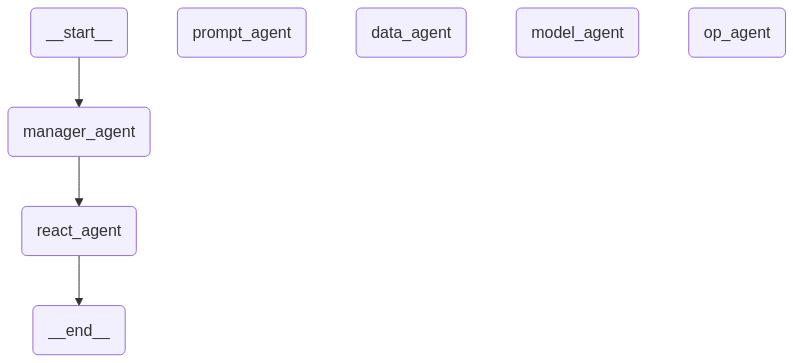

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles



display(
	Image(
		app.get_graph().draw_mermaid_png(
			draw_method=MermaidDrawMethod.API, 
		)
	)
)

In [ ]:
def main() -> None:
	"""Nhận truy vấn từ người dùng và hiển thị kết quả phản hồi."""
	while True: 
		user_query = input("👨_query: ")
		if user_query.lower() == "exit":
			print(">>> SystemExit: Goodbye! Have a great day!😊")
			break
		print_stream(
			app.stream(input={"user_query": [user_query]}, 
			stream_mode="values", config=CONFIG)
	)



def print_stream(stream) -> None:
	"""Hiển thị kết quả hội thoại theo cách dễ đọc hơn."""
	for s in stream:
		if len(list(s.keys())) == 2:
			messages = s["messages"]
			if "SYSTEM" in messages and messages["SYSTEM"]:
				print("\n ⚙️ **SYSTEM**:")
				messages["SYSTEM"][-1].pretty_print()

			if "HUMAN" in messages and messages["HUMAN"]:
				print("\n 👨 **HUMAN**:")
				messages["HUMAN"][-1].pretty_print()

			if "AI" in messages and messages["AI"]:
				print("\n 🤖 **AI**:")
				messages["AI"][-1].pretty_print()
			print("🔹" * 30)



if __name__ == "__main__":
	fire.Fire(main)

In [ ]:
prompt = [HumanMessage("What is the capital of France?")]

In [ ]:
model.invoke(prompt)

In [ ]:
system_msg = SystemMessage("""You are a helpful assistant that responds to questions with three exclamation marks.""")
human_msg = HumanMessage('What is the capital of France?')
model.invoke([system_msg, human_msg])

In [ ]:
from langchain_core.prompts import PromptTemplate
template = PromptTemplate.from_template("""Answer the question based on the context below. If the question cannot be answered using the information provided, answer with "I don't know".

Context: {context}

Question: {question}

Answer: """)

template.invoke({"context": """The most recent advancements in NLP are being driven by Large Language Models (LLMs). These models outperform their smaller counterparts and have become invaluable for developers who are creating applications with NLP capabilities. Developers can tap into these models through Hugging Face's `transformers` library, or by utilizing OpenAI and Cohere's offerings through the `openai` and `cohere` libraries, respectively.""",
	"question": "Which model providers offer LLMs?"
})

In [ ]:
completion = model.invoke(prompt)

In [ ]:
from pydantic import BaseModel
class AnswerWithJustification(BaseModel):
	'''An answer to the user's question along with justification for the answer.'''
	answer: str
	'''The answer to the user's question'''
	justification: str
	'''Justification for the answer'''

In [ ]:
structured_llm = model.with_structured_output(AnswerWithJustification)
structured_llm

In [ ]:
structured_llm.invoke("What weighs more, a pound of bricks or a pound of feathers")